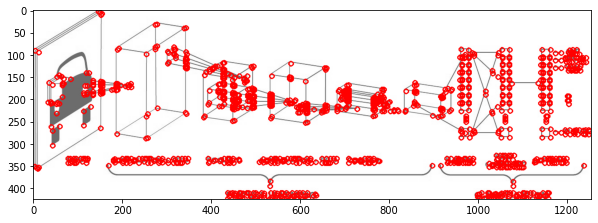

In [5]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt


# Kernel operation using input operator of size 3*3
def GetSobel(image, Sobel, width, height):
    # Initialize the matrix
    I_d = np.zeros((width, height), np.float32)

    # For every pixel in the image
    for rows in range(width):
        for cols in range(height):
            # Run the Sobel kernel for each pixel
            if rows >= 1 or rows <= width-2 and cols >= 1 or cols <= height-2:
                for ind in range(3):
                    for ite in range(3):
                        I_d[rows][cols] += Sobel[ind][ite] * image[rows - ind - 1][cols - ite - 1]
            else:
                I_d[rows][cols] = image[rows][cols]

    return I_d


# Method implements the Harris Corner Detection algorithm
def HarrisCornerDetection(image):

    # The two Sobel operators - for x and y direction
    SobelX = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    SobelY = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    w, h = image.shape

    # X and Y derivative of image using Sobel operator
    ImgX = GetSobel(image, SobelX, w, h)
    ImgY = GetSobel(image, SobelY, w, h)

    # # Eliminate the negative values
    # There are multiple ways this can be done
    # 1. Off setting with a positive value (commented out below)
    # 2. Setting negative values to Zero (commented out)
    # 3. Multiply by -1 (implemented below, found most reliable method)
    # ImgX += 128.0
    # ImgY += 128.0
    for ind1 in range(w):
        for ind2 in range(h):
            if ImgY[ind1][ind2] < 0:
                ImgY[ind1][ind2] *= -1
                # ImgY[ind1][ind2] = 0
            if ImgX[ind1][ind2] < 0:
                ImgX[ind1][ind2] *= -1
                # ImgX[ind1][ind2] = 0

    # # Display the output results after Sobel operations
    # cv2.imshow("SobelX", ImgX)
    # cv2.imshow("SobelY", ImgY)

    ImgX_2 = np.square(ImgX)
    ImgY_2 = np.square(ImgY)

    ImgXY = np.multiply(ImgX, ImgY)
    ImgYX = np.multiply(ImgY, ImgX)

    #Use Gaussian Blur
    Sigma = 1.4
    kernelsize = (3, 3)

    ImgX_2 = cv2.GaussianBlur(ImgX_2, kernelsize, Sigma)
    ImgY_2 = cv2.GaussianBlur(ImgY_2, kernelsize, Sigma)
    ImgXY = cv2.GaussianBlur(ImgXY, kernelsize, Sigma)
    ImgYX = cv2.GaussianBlur(ImgYX, kernelsize, Sigma)
    # print(ImgXY.shape, ImgYX.shape)

    alpha = 0.06
    R = np.zeros((w, h), np.float32)
    # For every pixel find the corner strength
    for row in range(w):
        for col in range(h):
            M_bar = np.array([[ImgX_2[row][col], ImgXY[row][col]], [ImgYX[row][col], ImgY_2[row][col]]])
            R[row][col] = np.linalg.det(M_bar) - (alpha * np.square(np.trace(M_bar)))
    return R


#### Main Program ####
firstimagename = cv2.imread("/content/drive/MyDrive/CNN.jpeg")

# Get the first image
firstimage = cv2.imread('/content/drive/MyDrive/CNN.jpeg', cv2.IMREAD_GRAYSCALE)
w, h = firstimage.shape

# Covert image to color to draw colored circles on it
bgr = cv2.cvtColor(firstimage, cv2.COLOR_GRAY2RGB)

# Corner detection
R = HarrisCornerDetection(firstimage)

# Empirical Parameter
# This parameter will need tuning based on the use-case
CornerStrengthThreshold = 500000

# Plot detected corners on image
radius = 5
color = (255, 0, 0)  # Red
thickness = 2

PointList = []
# Look for Corner strengths above the threshold
for row in range(w):
    for col in range(h):
        if R[row][col] > CornerStrengthThreshold:
            # print(R[row][col])
            max = R[row][col]

            # Local non-maxima suppression
            skip = False
            for nrow in range(5):
                for ncol in range(5):
                    if row + nrow - 2 < w and col + ncol - 2 < h:
                        if R[row + nrow - 2][col + ncol - 2] > max:
                            skip = True
                            break

            if not skip:
                # Point is expressed in x, y which is col, row
                cv2.circle(bgr, (col, row), radius, color, thickness)
                PointList.append((row, col))

# Display image indicating corners and save it
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(30)
plt.imshow(bgr)
outname = "Output_" + str(CornerStrengthThreshold) + ".png"
cv2.imwrite(outname, bgr)

cv2.waitKey(0)
cv2.destroyAllWindows()